In [ ]:
!pip install librosa soundfile numpy scikit-learn matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/speech-emotion-recognition-ravdess-data.zip -d /content/ravdess

Archive:  /content/drive/MyDrive/speech-emotion-recognition-ravdess-data.zip
   creating: /content/ravdess/Actor_01/
  inflating: /content/ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: /content/rav

In [ ]:
import librosa
import numpy as np

def augment_audio(file_name):
    y, sr = librosa.load(file_name)
    # Time Stretching
    y_stretch = librosa.effects.time_stretch(y, rate=1.2)
    # Pitch Shifting
    y_shift = librosa.effects.pitch_shift(y, sr, n_steps=4)
    # Adding Noise
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise
    return [y_stretch, y_shift, y_noise]

In [ ]:
import soundfile

def extract_feature(file_name, mfcc=True, chroma=True, mel=True, zcr=True, contrast=True, tonnetz=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
        if zcr:
            zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)
            result = np.hstack((result, zcr))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [ ]:
import glob
import os
from sklearn.model_selection import train_test_split

# Function to extract speaker ID from file name
def get_speaker_id(file_name):
    return file_name.split("-")[-1].split(".")[0]

# List of speakers to observe (all speakers in the dataset)
observed_speakers = [f'speaker{i}' for i in range(1, 25)]

# Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x, y = [], []
    for file in glob.glob("/content/ravdess/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        speaker = f'speaker{int(file_name.split("-")[-1].split(".")[0]):02d}'
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True, zcr=True, contrast=True, tonnetz=True)
        x.append(feature)
        y.append(speaker)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

x_train, x_test, y_train, y_test = load_data(test_size=0.25)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Multi Layer Perceptron Classifier
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

# Train the model
model.fit(x_train, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

Accuracy: 92.77778%


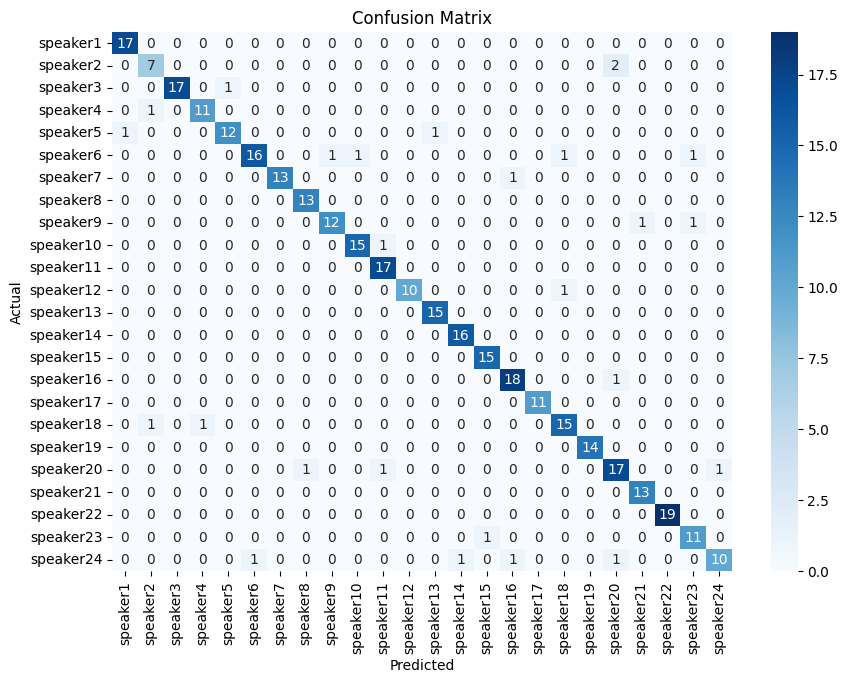

Classification Report:
              precision    recall  f1-score   support

    speaker1       0.94      1.00      0.97        17
    speaker2       0.78      0.78      0.78         9
    speaker3       1.00      0.94      0.97        18
    speaker4       0.92      0.92      0.92        12
    speaker5       0.92      0.86      0.89        14
    speaker6       0.94      0.80      0.86        20
    speaker7       1.00      0.93      0.96        14
    speaker8       0.93      1.00      0.96        13
    speaker9       0.92      0.86      0.89        14
   speaker10       0.94      0.94      0.94        16
   speaker11       0.89      1.00      0.94        17
   speaker12       1.00      0.91      0.95        11
   speaker13       0.94      1.00      0.97        15
   speaker14       0.94      1.00      0.97        16
   speaker15       0.94      1.00      0.97        15
   speaker16       0.90      0.95      0.92        19
   speaker17       1.00      1.00      1.00        11
   s

In [ ]:
# Predict for the test set
y_pred = model.predict(x_test)

# Calculate the accuracy of our model
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Accuracy: {:.5f}%".format(accuracy*100))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=observed_speakers, yticklabels=observed_speakers)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=observed_speakers))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'hidden_layer_sizes': [(100,), (200,), (300,)],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 500]
}

grid = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

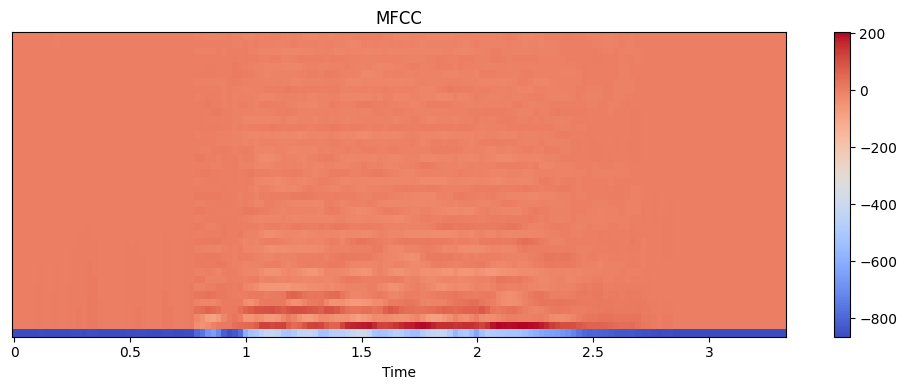

In [ ]:
import librosa.display

def plot_features(y, sr):
    plt.figure(figsize=(10, 4))
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

y, sr = librosa.load('/content/ravdess/Actor_01/03-01-01-01-01-02-01.wav')
plot_features(y, sr)

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1
  libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53
  libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick
  ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-free

In [ ]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Colab\ Notebooks/Untitled0.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb to pdf
[NbConvertApp] Support files will be in Untitled0_files/
[NbConvertApp] Making directory ./Untitled0_files
[NbConvertApp] Making directory ./Untitled0_files
[NbConvertApp] Writing 166882 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 166405 bytes to /content/drive/MyDrive/Colab Notebooks/Untitled0.pdf
